## Import Libraries

In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from time import localtime
from tqdm.notebook import tqdm

## Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Training Functions

In [3]:
def train_epoch(net, criterion, optimizer, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  train_loss = 0
  train_accuracy = 0
  i = 0

  net.train()
  for i, (x, y) in tqdm(enumerate(dataloader)):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)

    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    train_loss = epoch_loss / (i + 1)
    train_accuracy = epoch_true / epoch_all

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return train_loss, train_accuracy


def evaluate_epoch(net, criterion, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  eval_loss = 0
  eval_accuracy = 0
  i = 0

  net.eval()
  for i, (x, y) in tqdm(enumerate(dataloader)):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)

    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    eval_loss = epoch_loss / (i + 1)
    eval_accuracy = epoch_true / epoch_all

  return eval_loss, eval_accuracy


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, criterion, optimizer, train_loader, test_loader=None, name='best_model'):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    min_test_loss = np.inf

    for e in range(n_epochs):
        train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(float(train_accuracy))

        if test_loader is not None:
            test_loss, test_accuracy = evaluate_epoch(net, criterion, test_loader)
            test_losses.append(test_loss)
            test_accuracies.append(float(test_accuracy))
            if float(test_loss) < min_test_loss:
                min_test_loss = float(test_loss)
                torch.save(net, name)

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
        if test_loader is not None:
            print(f'Test Loss: {test_loss:.4f}\t\tTest Accuracy: {test_accuracy:.2f}')
        else:
            print()

    return train_losses, train_accuracies, test_losses, test_accuracies


def test_model(net, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    eval_loss = 0
    eval_accuracy = 0
    i = 0
    y_hat = torch.tensor([]).to(device)

    with torch.no_grad():
        net.eval()
        for i, (x, y) in tqdm(enumerate(dataloader)):
            x = x.to(device)
            y = y.to(device)

            p = net(x)
            y_hat = torch.cat((y_hat, p), 0)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            eval_loss = epoch_loss / (i + 1)
            eval_accuracy = epoch_true / epoch_all

    return y_hat, eval_loss, eval_accuracy

## Import Data

In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 177800871.75it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39329770.72it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 160290441.68it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6887392.90it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Shape of the image of the first data: torch.Size([1, 28, 28])
Label of the first data: 5


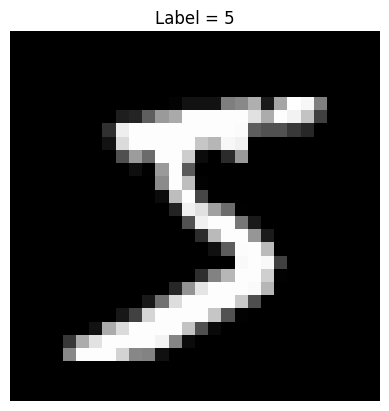

In [5]:
# Choosing one data and visualizing it
print(f"Shape of the image of the first data: {train_data[0][0].shape}")
print(f"Label of the first data: {train_data[0][1]}")

# Visualizing it
img, label = train_data[0]
plt.title(f"Label = {label}")
plt.imshow(img.squeeze(), cmap="gray")
plt.axis(False)
plt.show()

In [6]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Define Model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.fc(x)
        return y

In [9]:
model = NeuralNetwork().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
           Sigmoid-5                   [-1, 10]               0
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


In [10]:
print(model)

NeuralNetwork(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): Sigmoid()
  )
)


## Test Model

In [11]:
learning_rate = 1e-3
n_epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, train_acc, val_loss, val_acc = train_model(model, n_epochs, criterion, optimizer, train_dataloader, test_dataloader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[Epoch 1]	 [12:16:12]	Train Loss: 1.5670	Train Accuracy: 0.91	Test Loss: 1.5170		Test Accuracy: 0.94


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[Epoch 2]	 [12:16:21]	Train Loss: 1.5065	Train Accuracy: 0.95	Test Loss: 1.4984		Test Accuracy: 0.96


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[Epoch 3]	 [12:16:31]	Train Loss: 1.4936	Train Accuracy: 0.97	Test Loss: 1.4944		Test Accuracy: 0.97


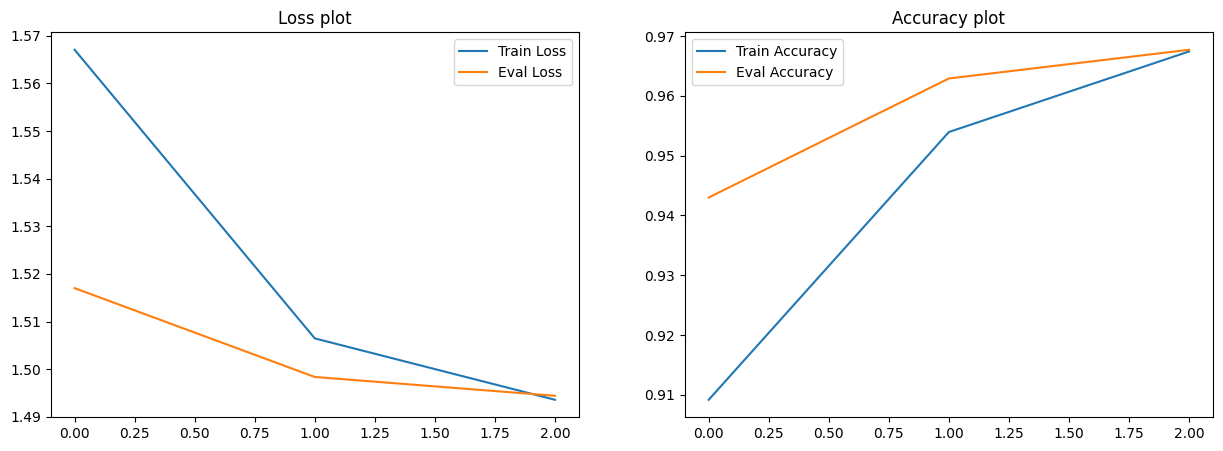

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(val_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Eval Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(val_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Eval Accuracy'])

plt.show()